## Описание данных

#### Датасет, с которым мы будем работать – данные о поездках в Нью-Йорке. 
- **pickup_datetime** — дата начала поездки
- **pickup_longitude** — долгота исходного местоположения
- **pickup_latitude** — широта исходного местоположения
- **dropoff_longitude** — долгота пункта назначения
- **dropoff_latitude** — широта пункта назначения
- **fare_amount** — стоимость поездки в долларах 
- **passenger_count** — число пассажиров

In [1]:
# Импорт библиотек
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
nyc = pd.read_csv('nyc_data.csv')
nyc.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [3]:
nyc.shape

(50000, 8)

#### 1) Ваша задача – написать функцию haversine для подсчета расстояния между пунктами отправления и прибытия и создать колонку distance с подсчитанным расстоянием. Для решения этой задачи воспользуйтесь формулой гаверсинуса:


$d=2r * arcsin\left(\sqrt{sin^2\left(\cfrac{φ2 - φ1}{2}\right)+cos(φ1)*cos(φ2) * sin^2\left(\cfrac{λ2 - λ1}{2}\right)}\right)$, где

- **φ1 и φ2**  — широта исходного местоположения и широта пункта назначения в радианах,
- **λ1 и λ2** — долгота исходного местоположения и долгота пункта назначения в радианах,
- **r** — радиус сферы, будем считать его равным 6371.

In [4]:
def haversine(latitude1, longitude1, latitude2, longitude2, radius=6371):
    """Function calculates the great-circle distance between two points.
    
    Parameters
    ---------
    latitude1: the latitude of the point 1
    longitude1: the longitude of the point 1
    latitude2: the latitude of the point 2
    longitude2: the longitude of the point 2
    """
    
    f1_rad = np.radians(latitude1)
    f2_rad = np.radians(latitude2)
    lam1_rad = np.radians(longitude1)
    lam2_rad = np.radians(longitude2)
    sin_f = np.sin((f2_rad - f1_rad)/2) ** 2
    sin_lam = np.sin((lam2_rad - lam1_rad)/2) ** 2
    return 2 * radius * np.arcsin(np.sqrt(sin_f + np.cos(f1_rad) * np.cos(f2_rad) * sin_lam))

In [5]:
# Вычисление через pd.Series
nyc['distance'] = haversine(nyc.pickup_latitude, nyc.pickup_longitude, nyc.dropoff_latitude, nyc.dropoff_longitude)

In [6]:
# Векторизованные операции над numpy arrays более эффективны
nyc['distance'] = haversine(nyc.pickup_latitude.values, nyc.pickup_longitude.values,
                            nyc.dropoff_latitude.values, nyc.dropoff_longitude.values)

#### 2) В переменную longest сохраните самое большое расстояние. 

In [7]:
longest = nyc['distance'].loc[nyc['distance'].idxmax()]
longest

8667.818812217456

#### 3) Как вы уже заметили, произошло что-то странное: в качестве широты и долготы стоят нулевые значения, а расстояние — целых 8667 км! Неужели наш пассажир действительно уехал так далеко?
#### Посмотрите, есть ли еще кейсы, где в качестве хотя бы одной из координат пункта назначения стоят нули, и в качестве ответа укажите количество таких случаев.

In [8]:
nyc.query('dropoff_latitude == 0 or dropoff_longitude == 0').shape[0]

958

#### 4) Предположим, наша цель всё ещё состоит в поиске самых дальних поездок. Естественно, текущие данные совсем не годятся — некоторые такси, согласно данным, уезжают и приезжают из океана.

#### Постройте графики распределения переменных pickup_latitude, pickup_longitude, dropoff_latitude, dropoff_longitude, и для каждой переменной выберите только один наиболее подходящий вариант для дальнейшей фильтрации данных.

array([[<AxesSubplot:title={'center':'pickup_longitude'}>,
        <AxesSubplot:title={'center':'pickup_latitude'}>],
       [<AxesSubplot:title={'center':'dropoff_longitude'}>,
        <AxesSubplot:title={'center':'dropoff_latitude'}>]], dtype=object)

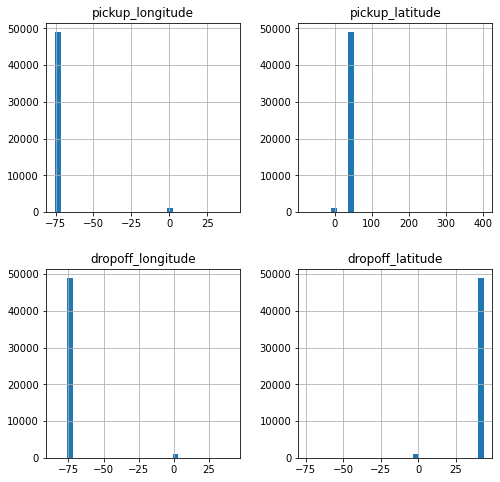

In [9]:
nyc[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']].hist(figsize=(8, 8), bins=30)

- 10 < pickup_latitude < 120
- pickup_longitude < -60
- 10 < dropoff_latitude
- dropoff_longitude < -60

#### Критерии для фильтрации выбраны, остался последний шаг: отфильтровать имеющиеся данные и наконец-то найти самую дальнюю поездку. Tакже добавьте еще одно ограничение для переменной distance. Предположим, максимальная удаленность пунктов друг от друга не должна превышать 50 километров, иначе такой заказ не будет принят системой, а наличие подобных результатов в таблице будет считаться ошибкой.

#### 7) В качестве ответа укажите сумму, которую заплатил пассажир, проехавший наибольшее расстояние.

In [10]:
filtered_rides = nyc.query('(pickup_longitude < -60) & (pickup_latitude < 120) & \
                       (pickup_latitude > 10) & (dropoff_latitude > 10) & \
                       (dropoff_longitude < -60)  & (distance < 50)')

In [11]:
longest_trip = filtered_rides.query('distance == distance.max()')
longest_trip

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance
33502,2014-02-22 02:44:00.00000052,136.0,2014-02-22 02:44:00 UTC,-73.98954,40.757032,-73.86058,41.147487,1,44.746988
